# IEEE CIS Fraud Detection
## Exploration of Data
By: Michael Mehallow

This notebook is a general exploratory analysis of the data used. It includes the majority of the exploration I undertook to understand the data and perform feature engineering. One of the main challenges of this competition was that the vast majority of meanings of the columns were hidden.

Through this analysis, as well as fellow Kagglers, the meaning of certain features was discovered. This notebook enabled me to discover a number of key features of the data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import time
import pickle

In [5]:
file = open('train_test.pickle', 'rb')
all_train, all_y_train, all_test = pickle.load(file)    

# Randomly sample 10% of the data to make visualization easier
train = all_train.sample(frac=0.1)

In [6]:
len(train)

59054

## Exploration

Start out by understanding the size of the training data.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59054 entries, 3316052 to 3327115
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(1), int8(1), object(31)
memory usage: 64.8+ MB


In [8]:
# Percent of fraudulent transactions
train['isFraud'].mean()

0.035171199241372304

There is significant class imbalance in the training data, with just 3.5% of samples being fradulent. This class imbalance will need to be balanced as part of the data pipeline.

### Product Category
One of the interesting features, that we have some information on is ProductCD. Below is an exploration of the properties of each category.

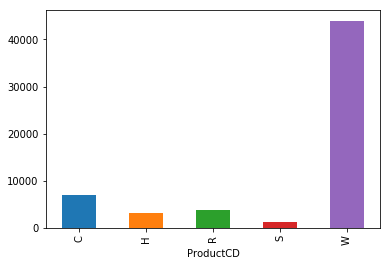

In [10]:
train.groupby(['ProductCD'])['ProductCD'].count().plot.bar()

There are signficantly more "W" class of ProductCD. Any additional information about clases needs to be inferred from the data.

Potentially some information could be gained by looking at if there is addresses, email domains, and device id fields associated with the groups.

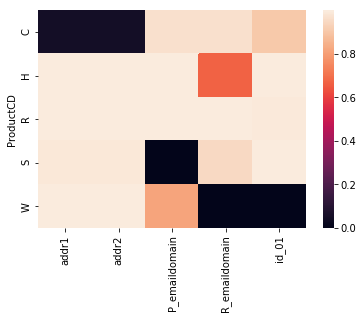

In [17]:
sns.heatmap(train.groupby(['ProductCD'])[['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'id_01']].apply(lambda x: 1-x.isna().mean()))

This is very interesting.

Product W, the most frequent almost always has addresses, but rarely has a recepient email or device id associated with it.

Product C: Does not have addr1 or addr 2

Product S: Does not have P_emaildomain

Product H: Sometimes does not have R_emaildomain

Next I would like to check if group has a higher percent of fradulent transactions.

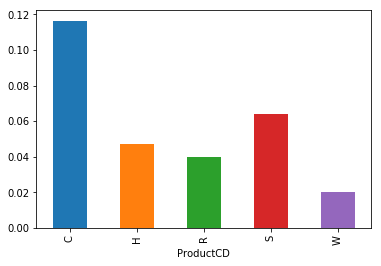

In [20]:
train.groupby('ProductCD')['isFraud'].mean().plot.bar()

Product C contains nearly 2-3 times the rate of fraudulent transactions of the other classes. Class W, the largest, has the smallest rate of fraud.

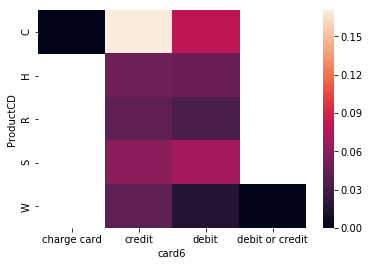

In [21]:
sns.heatmap(train.groupby(['ProductCD', 'card6'])['isFraud'].mean().unstack('card6'))

## Card Features 
There are a number of card features which can help identify users.

In [22]:
card_cols = [x for x in train.columns if 'card' in x]
print(card_cols)

['card1', 'card2', 'card3', 'card4', 'card5', 'card6']


Lets take a peek at the data...

In [36]:
train[card_cols].head()

,card1,card2,card3,card4,card5,card6
TransactionID,,,,,,
3316052,16075,514.0,150.0,mastercard,102.0,credit
3366066,11839,490.0,150.0,visa,226.0,debit
3544715,10057,225.0,150.0,mastercard,224.0,debit
3116041,3181,152.0,150.0,visa,226.0,debit
3411631,11159,253.0,150.0,mastercard,224.0,debit


(0, 1)

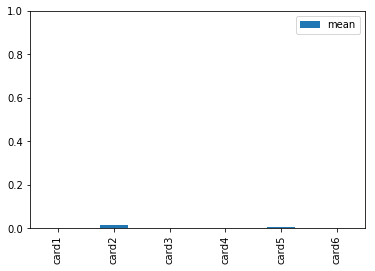

In [27]:
train[card_cols].isna().agg(['mean']).T.plot.bar()
plt.ylim([0, 1])

In [29]:
train[card_cols].isna().agg(['mean'])

,card1,card2,card3,card4,card5,card6
mean,0.0,0.014868,0.002659,0.002676,0.006994,0.002659


Very few card fields are missing. No records are missing card1!

Card 1 is an identifier of an account.

One piece of interesting information will be the number of transactions for each card. And what is the typical number of transactions per card in the training set. This is shown below.

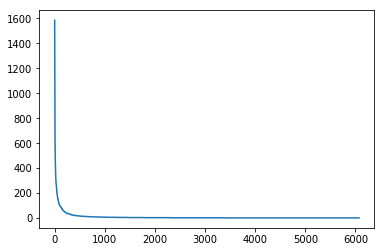

In [32]:
card1_value_counts = train['card1'].value_counts().sort_values(ascending=False).values
plt.plot(card1_value_counts)
plt.show()

This diagram shows the majority of card1s have very few transactions, and some card1s have a very high number of transactions.

Next, we repeat for card2.

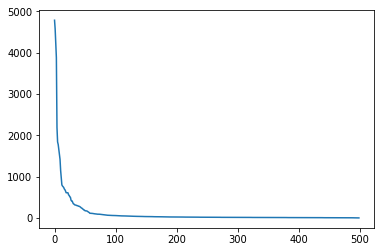

In [34]:
card2_value_counts = train['card2'].value_counts().sort_values(ascending=False).values
plt.plot(card2_value_counts)
plt.show()

## Address exploration

addr1 and addr2 are actually categorical variable corresponding to country/state region. Unfortunately we aren't given the specifics.

In [52]:
print('Number of unique addr1 : ' + str(len(set(train.addr1.dropna()))))
print('Number of unique addr2 : ' + str(len(set(train.addr2.dropna()))))

Number of unique addr1 : 144
Number of unique addr2 : 28


The following figure shows that the majority of samples come from 40 different addr1 areas.

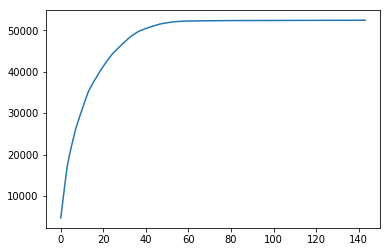

In [46]:
addr1_value_counts = train['addr1'].value_counts().sort_values(ascending=False).values.cumsum()
plt.plot(addr1_value_counts)
plt.show()

The cumulative sum by addr2 is even more interesting. This shows that there are signficantly less different addr2 values And that the majority of samples have one of 3 different addr2 values.

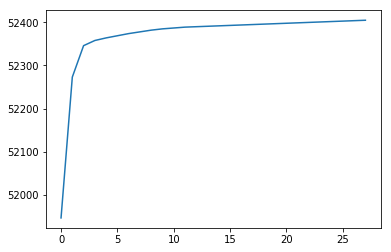

In [51]:
addr2_value_counts = train['addr2'].value_counts().sort_values(ascending=False).values.cumsum()
plt.plot(addr2_value_counts)
plt.show()

## Distance

Also included is dist1 and dist2, which can represent distance. I assume that larger distances may correspond with a remote person who has stolen account/card attempting to use the card. Therfore I think it is likely that distance is an important predictive feature.

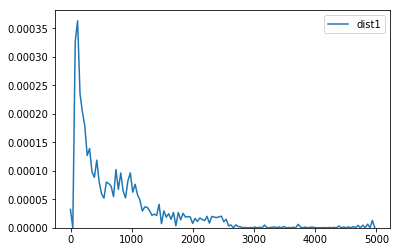

In [58]:
sns.kdeplot(train.dist1.dropna())
plt.show()

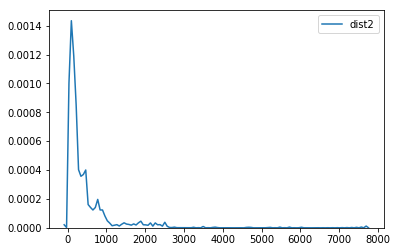

In [59]:
sns.kdeplot(train.dist2.dropna())
plt.show()

[]

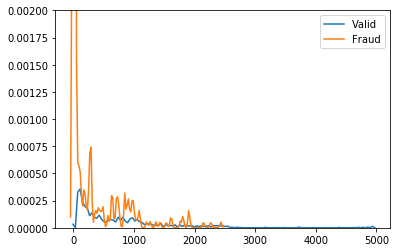

In [62]:
isfraud_idx = train['isFraud']==1
sns.kdeplot(train[~isfraud_idx].dist1.dropna(), label='Valid')
sns.kdeplot(train[isfraud_idx].dist1.dropna(), label='Fraud')
plt.ylim([0, 0.002])
plt.plot()

## Email Exploration
The data also includes email addresses. These could provide valuable information.

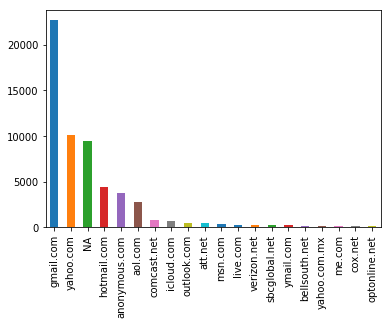

In [68]:
train['P_emaildomain'].fillna('NA').value_counts()[:20].plot.bar()

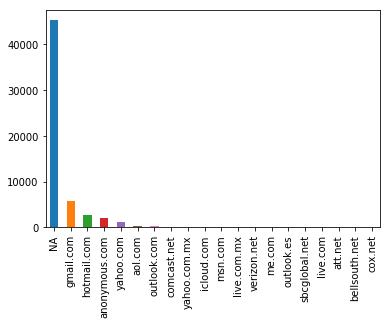

In [69]:
train['R_emaildomain'].fillna('NA').value_counts()[:20].plot.bar()

### Extract email country end

In [70]:
train['P_emailloc'] = train['P_emaildomain'].str.extract("\.(.*)").fillna('na')
train['R_emailloc'] = train['R_emaildomain'].str.extract("\.(.*)").fillna('na')

In [71]:
train.groupby(['R_emailloc'])['isFraud'].agg(['mean', 'sum', 'count']).sort_values(by='mean', ascending=False)

,mean,sum,count
R_emailloc,,,
es,0.118812,12.0,101
com,0.086553,1109.0,12813
com.mx,0.039370,10.0,254
na,0.020822,942.0,45240
net,0.007812,4.0,512
co.jp,0.000000,0.0,6
co.uk,0.000000,0.0,11
de,0.000000,0.0,52
edu,0.000000,0.0,3


## Time Delta Features

There are also several time delta features, these may contain important information.

In [78]:
delta_features = [x for x in train.columns if x[0]=='D' and len(x)==2]

In [79]:
print(delta_features)

['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']


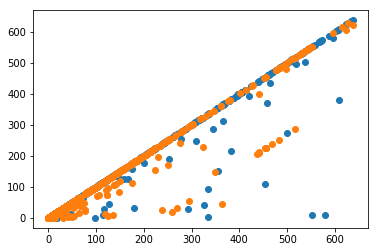

In [82]:
isfraud_idx = train.isFraud==1
feature_x = 'D1'
feature_y = 'D2'
plt.plot(train[~isfraud_idx][:1000][feature_x], train[~isfraud_idx][:1000][feature_y], 'o')
plt.plot(train[isfraud_idx][feature_x],          train[isfraud_idx][feature_y], 'o')

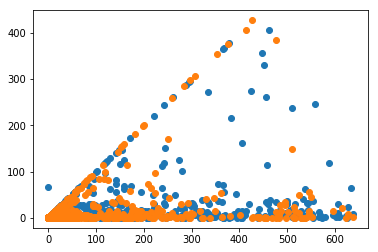

In [83]:
isfraud_idx = train.isFraud==1
feature_x = 'D1'
feature_y = 'D3'
plt.plot(train[~isfraud_idx][:1000][feature_x], train[~isfraud_idx][:1000][feature_y], 'o')
plt.plot(train[isfraud_idx][feature_x],          train[isfraud_idx][feature_y], 'o')

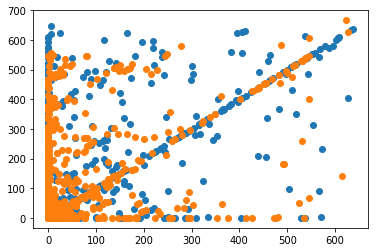

In [84]:
isfraud_idx = train.isFraud==1
feature_x = 'D1'
feature_y = 'D4'
plt.plot(train[~isfraud_idx][:1000][feature_x], train[~isfraud_idx][:1000][feature_y], 'o')
plt.plot(train[isfraud_idx][feature_x],          train[isfraud_idx][feature_y], 'o')

## Train Idenitification info

In [86]:
id_columns = [x for x in train.columns if x[:2]=='id']
print(id_columns)

['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [89]:
train[id_columns].dropna().head(5).T

TransactionID,3341098,3430535,3023054,3154848,3358675
id_01,-20,-20,-10,-5,-25
id_02,87574,11803,70547,75264,614
id_03,0,0,0,0,0
id_04,0,0,0,0,0
id_05,11,6,19,-18,2
id_06,-32,-31,-11,-100,-59
id_07,23,18,22,2,6
id_08,-45,-100,-9,-54,-48
id_09,0,0,0,0,0
id_10,0,0,0,-29,0


### Device Type counts

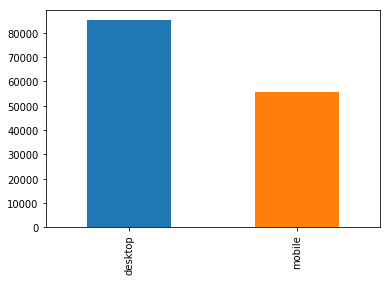

In [794]:
idf['DeviceType'].value_counts().plot.bar()

## Device Info Cleaning
We also have device info, but there are a lot of categories, and it would be helpful to reduce the number of categories. This is important for one-hot-encoding. (Although I didn't end up using this feature.)

In [104]:
def clean_device_info(x):
    if x[:2]=='SM':
        return 'Samsung'
    elif x[:3] == 'rv:':
        return 'Windows NT'
    elif 'huawei' in x.lower():
        return 'Huawei'
    elif x[:2] == 'LG':
        return 'LG'  
    elif 'SAMSUNG' in x:
        return 'Samsung'
    elif x[:4] == 'Moto':
        return 'Moto'
    elif x[:3] == 'HTC':
        return 'HTC'
    elif 'blade' in x.lower():
        return 'Blade'
    elif x!='nan':
        return 'Other'
    else:
        return x
    
train['DeviceInfo'] = train['DeviceInfo'].astype(str)
train['clean_DeviceInfo'] = train['DeviceInfo'].apply(clean_device_info)

Unfortunately even with the cleaning and grouping, there are still far more in other. More cleaning is needed here.

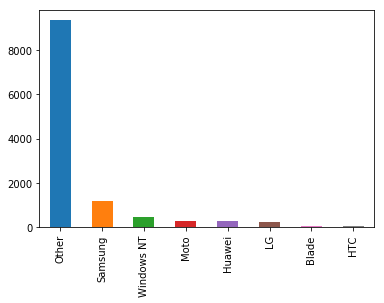

In [106]:
train[train['clean_DeviceInfo']!='nan']['clean_DeviceInfo'].value_counts()[:20].plot.bar()

### Match status

I assume match status is based on some aspects of the provided information or device used. I think this might be very important since I assume fradulent transactions will not have the same match status as valid transactions.

In [109]:
train['id_34'].value_counts()

match_status:2    5946
match_status:1    1713
match_status:0      40
Name: id_34, dtype: int64

In [113]:
match_columns = ['id_28', 'id_29', 'id_34']
train[match_columns].fillna('na').groupby(match_columns).apply(len)

id_28  id_29     id_34         
Found  Found     match_status:0       27
                 match_status:1      432
                 match_status:2     3793
                 na                 3178
       NotFound  match_status:0        1
                 match_status:1        2
                 match_status:2       98
                 na                   24
New    NotFound  match_status:0       12
                 match_status:1     1279
                 match_status:2     2055
                 na                 3230
na     na        na                44923
dtype: int64

## Transaction Amount

From what other Kaggler's recommended, transaction amount is important.

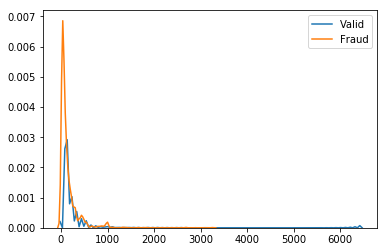

In [125]:
low_transactionamt = train['TransactionAmt']<10000
fraud = train.isFraud==1
sns.kdeplot(train[~fraud & low_transactionamt]['TransactionAmt'], label='Valid')
sns.kdeplot(train[fraud & low_transactionamt]['TransactionAmt'], label='Fraud')
plt.show()

There does not appear to be much difference in the amounts of fraudulent and valid transactions. 

One hint from other Kagglers is that the amount of cents is an important feature.  The figure below shows that the distribuion of cents between fradulent and valid transactions is different, which means there is useful predictive information in this feature.

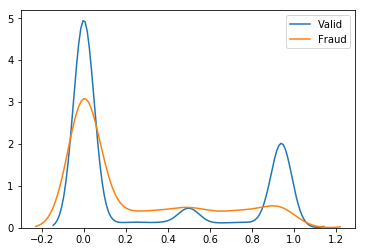

In [122]:
sns.kdeplot(train[train.isFraud==0]['TransactionAmt'] % 1, label='Valid')
sns.kdeplot(train[train.isFraud==1]['TransactionAmt'] % 1, label='Fraud')